In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [2]:
base_path = '/home/jim/Documents/AI/fact/reproduction/'
sys.path.insert(0, base_path)
from Model import *

In [3]:
model = Model.Initialize('vae', None, pretrained_path=f'{base_path}Models/vae.pt')

Loading the pretrained model...


In [4]:
# sys.path.insert(0, "../Code/")
# from load_scvis import load_vae

path = f'{base_path}/ELDR/Housing/Data/'


data_file = path + 'X.tsv'
target_file = path + 'y.tsv'
input_dim = 13
#model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"
num_clusters = 6

x = pd.read_csv(data_file, sep="\t").values
y = pd.read_csv(target_file, sep="\t").values



data_rep = model.Encode(x)

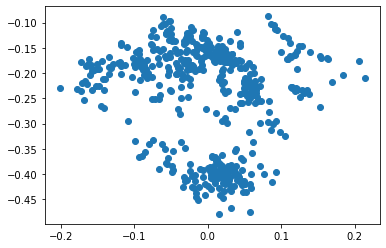

In [5]:
plt.scatter(data_rep[:,0], data_rep[:,1])
plt.show()

In [6]:
from sklearn.cluster import KMeans
num_clusters = 6

# rep = model.Encode(x)
kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)

In [7]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

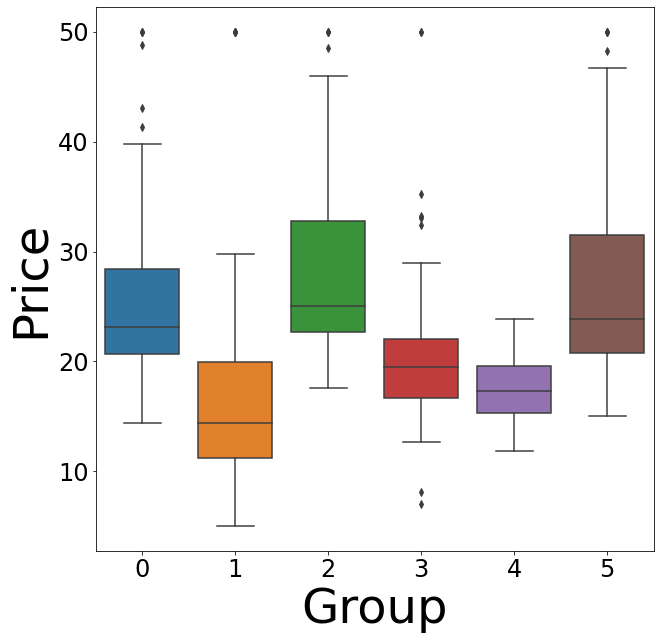

In [8]:
# See what signal is enocded in the clusters
import matplotlib.pyplot as plt
import seaborn as sns

labels = kmeans.labels_

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax = ax, x = labels, y = np.squeeze(y))
ax.set(xlabel = "Group", ylabel = "Price")
ax.get_figure().savefig("housing-labels.png")


In [9]:
from eldr.explain.explain_cs import *
epsilon = 0.045

Explainer = Explain(model, means, centers, use_scaling=True)

if True:
    print(Explainer.eval_epsilon(torch.tensor(x), indices, epsilon))
    

(1.0, 1.0, 1.0)


In [10]:
# with open('./epsilon.txt', 'r') as f:
#     e = f.readlines()
#     print(e)


In [11]:
results_path = f'{base_path}experiments/Housing_scaling/deltas/'
run = False

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = [1, 3, 5, 7, 9, 11, 13]
# if run:
#     os.system(f"rm {results_path}*.npy")
#     os.system(f"rm {results_path}out.csv")
    
#     out = np.zeros((len(K), 5))

#     c = 0
#     for k in K:
#         out[c, 0] = k
#         c += 1

In [12]:
import json
from types import SimpleNamespace
# best_val = 0.0
# ntrials = 1
# lg = 1.5
config = SimpleNamespace(**json.load(open(f'{base_path}configs/tgt.json', 'r')))


if run:
    c = 0
    for k in K:

        best_val = 0.0
        for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
            for trial in range(5):
                config.learning_rate = 0.01
                config.lambda_global = lg
                config.consecutive_steps = 5
                print(config)
                Explainer = Explain(model, means, centers, use_scaling=True)
                deltas, logit_gammas, _ = Explainer.explain(config)
                a, b = Explainer.metrics(x, indices, deltas, epsilon, k = k, logit_gammas=logit_gammas) 

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    out[c, 1] = best_val
                    out[c, 2] = np.mean(b)
                    np.save(f"{results_path}deltas" + str(k) + ".npy", deltas)
                    np.save(f"{results_path}logit_gammas" + str(k) + ".npy", logit_gammas)

                os.system("rm -rf explanation")
        c += 1

In [13]:
!ls

clusters.png	  housing-0to4.png  housing-labels.png	 synth-rep.png
deltas		  housing-1to4.png  housing-metrics.png
explanations	  housing-3to5.png  labels.png
housing-0to2.png  Housing.ipynb     out.csv


In [14]:

# for i in range(ntrials):
#     print("Trial: ", i)
#     Explainer = Explain(model, means, centers)
#     deltas, tgt = Explainer.explain(config)
#     a, b = Explainer.metrics(torch.tensor(x), indices, deltas, epsilon)
    
#     val = np.mean(a)
    
#     if val > best_val:
#         best_val = val
#         print("best_val ", best_val, "deltas ", deltas)
#         np.save("housing_deltas.npy", deltas)
    
#     os.system("rm -rf explanation")

[[ 0.10602073  0.13431345 -0.12090791  0.09449257  0.00295687 -0.0249969
   0.27704516  0.06470159  0.21752603  0.29438832  0.23775971 -0.07161672
   0.12338471]
 [ 0.04389859  0.08445819 -0.00509    -0.03017262 -0.29715976  0.07770427
  -0.07428985  0.16053993  0.09402798  0.03004442 -0.13762416 -0.02377007
   0.00813741]
 [ 0.00981782  0.00660405 -0.05746616  0.07180111  0.07231375 -0.02219849
   0.08351302 -0.02356407  0.03262211  0.09240641  0.09594128 -0.01355749
   0.0098462 ]
 [-0.0314982  -0.06116783 -0.0019518   0.03803358  0.21852927 -0.06827636
   0.03731167 -0.12751846 -0.08907131  0.00359611  0.12570693  0.01435005
  -0.02097096]
 [-0.00959841  0.00083167  0.03023954 -0.0396165  -0.12261433  0.03058205
  -0.08658353  0.04992679  0.01211185 -0.05824519 -0.11048636  0.00311737
  -0.01352001]]
[[ 0.00623543  0.01051807 -0.04833153  0.00278888 -0.01565847 -0.01425068
   0.20007694  0.00770269  0.09638488  0.15806644  0.15750445 -0.05848335
   0.04781404]
 [-0.00022419  0.01596

/home/jim/Documents/AI/fact/reproduction/eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/jim/anaconda3/envs/factai/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


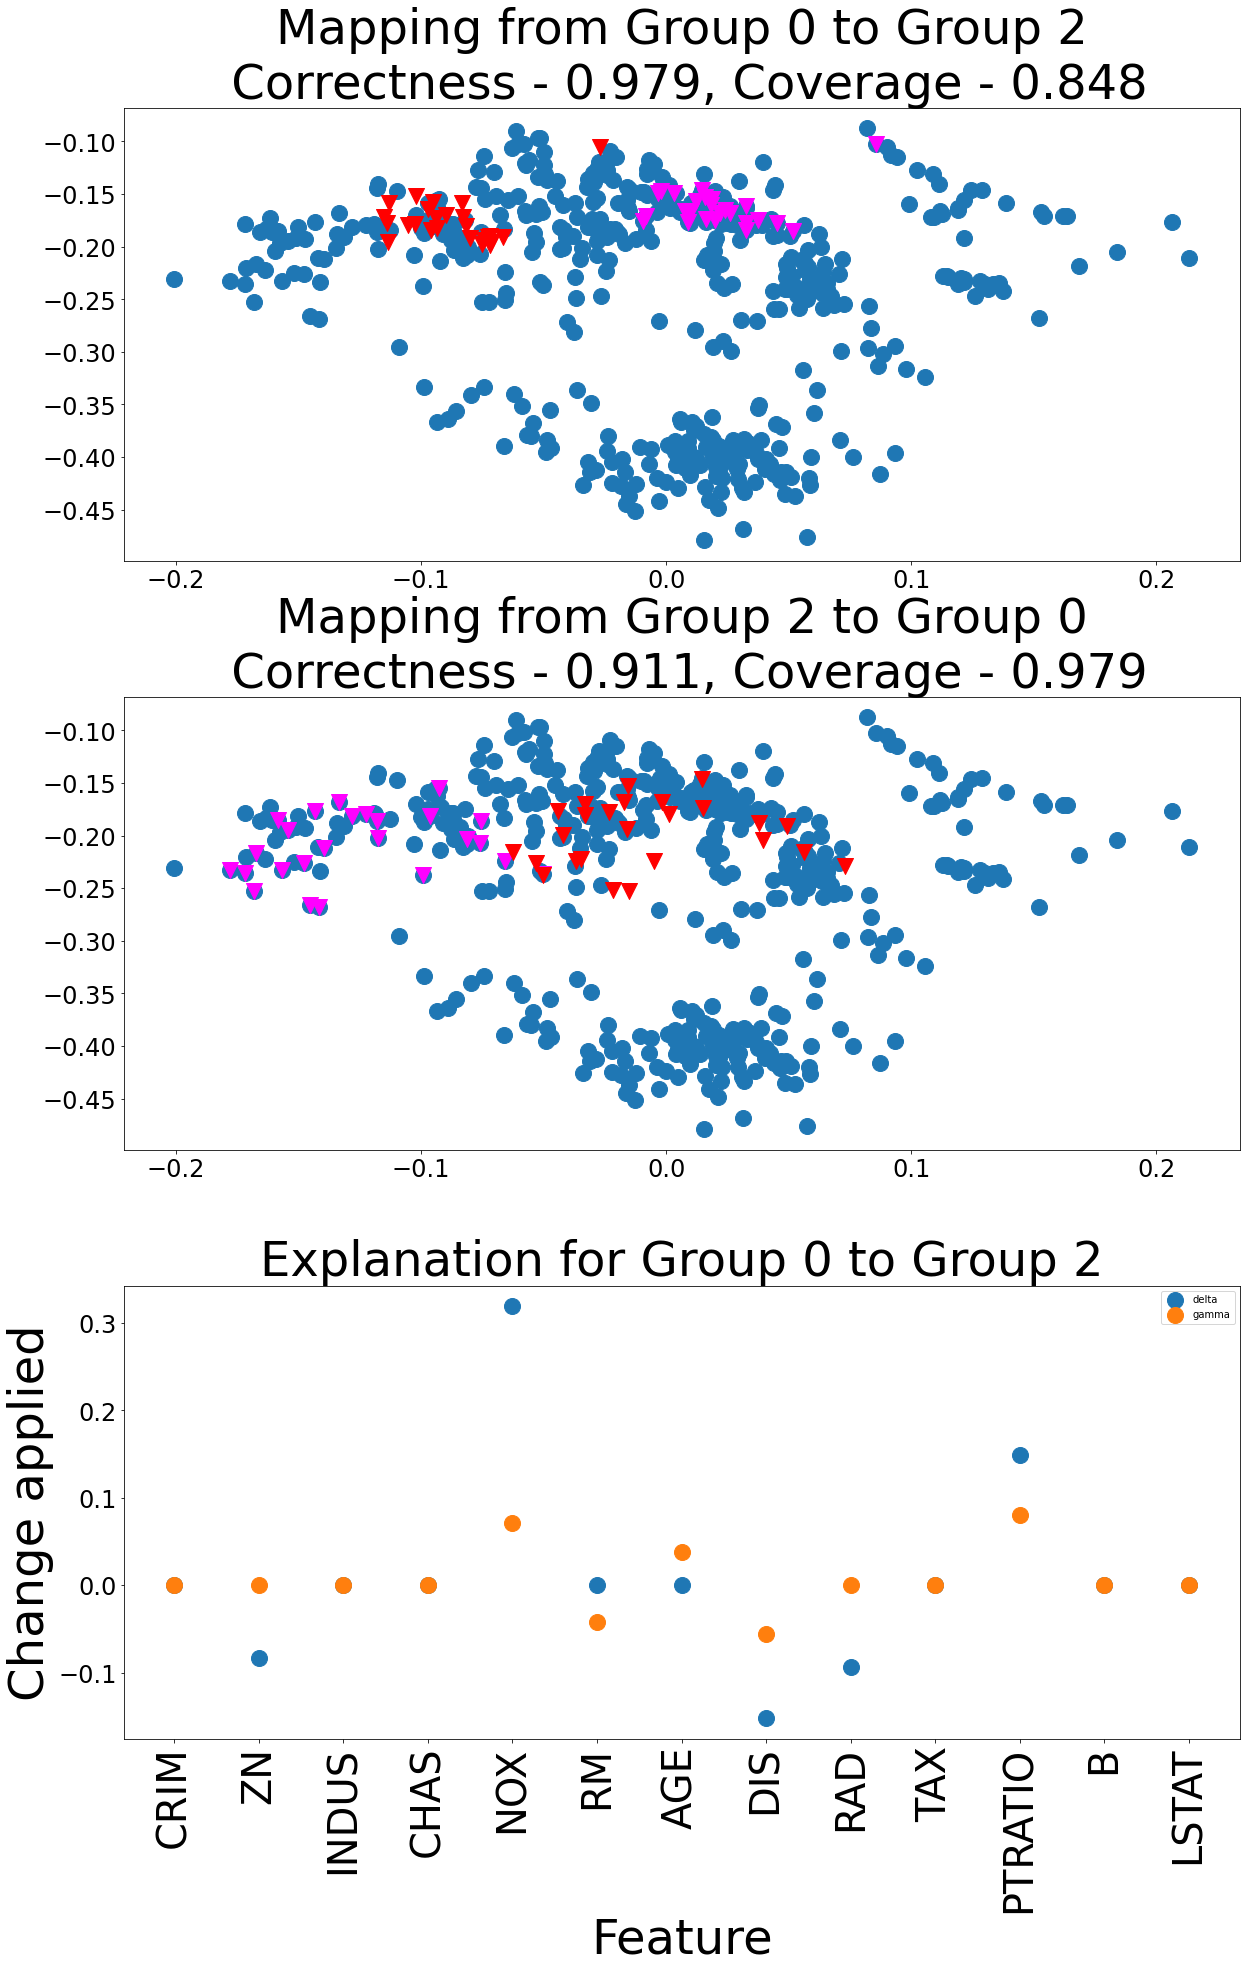

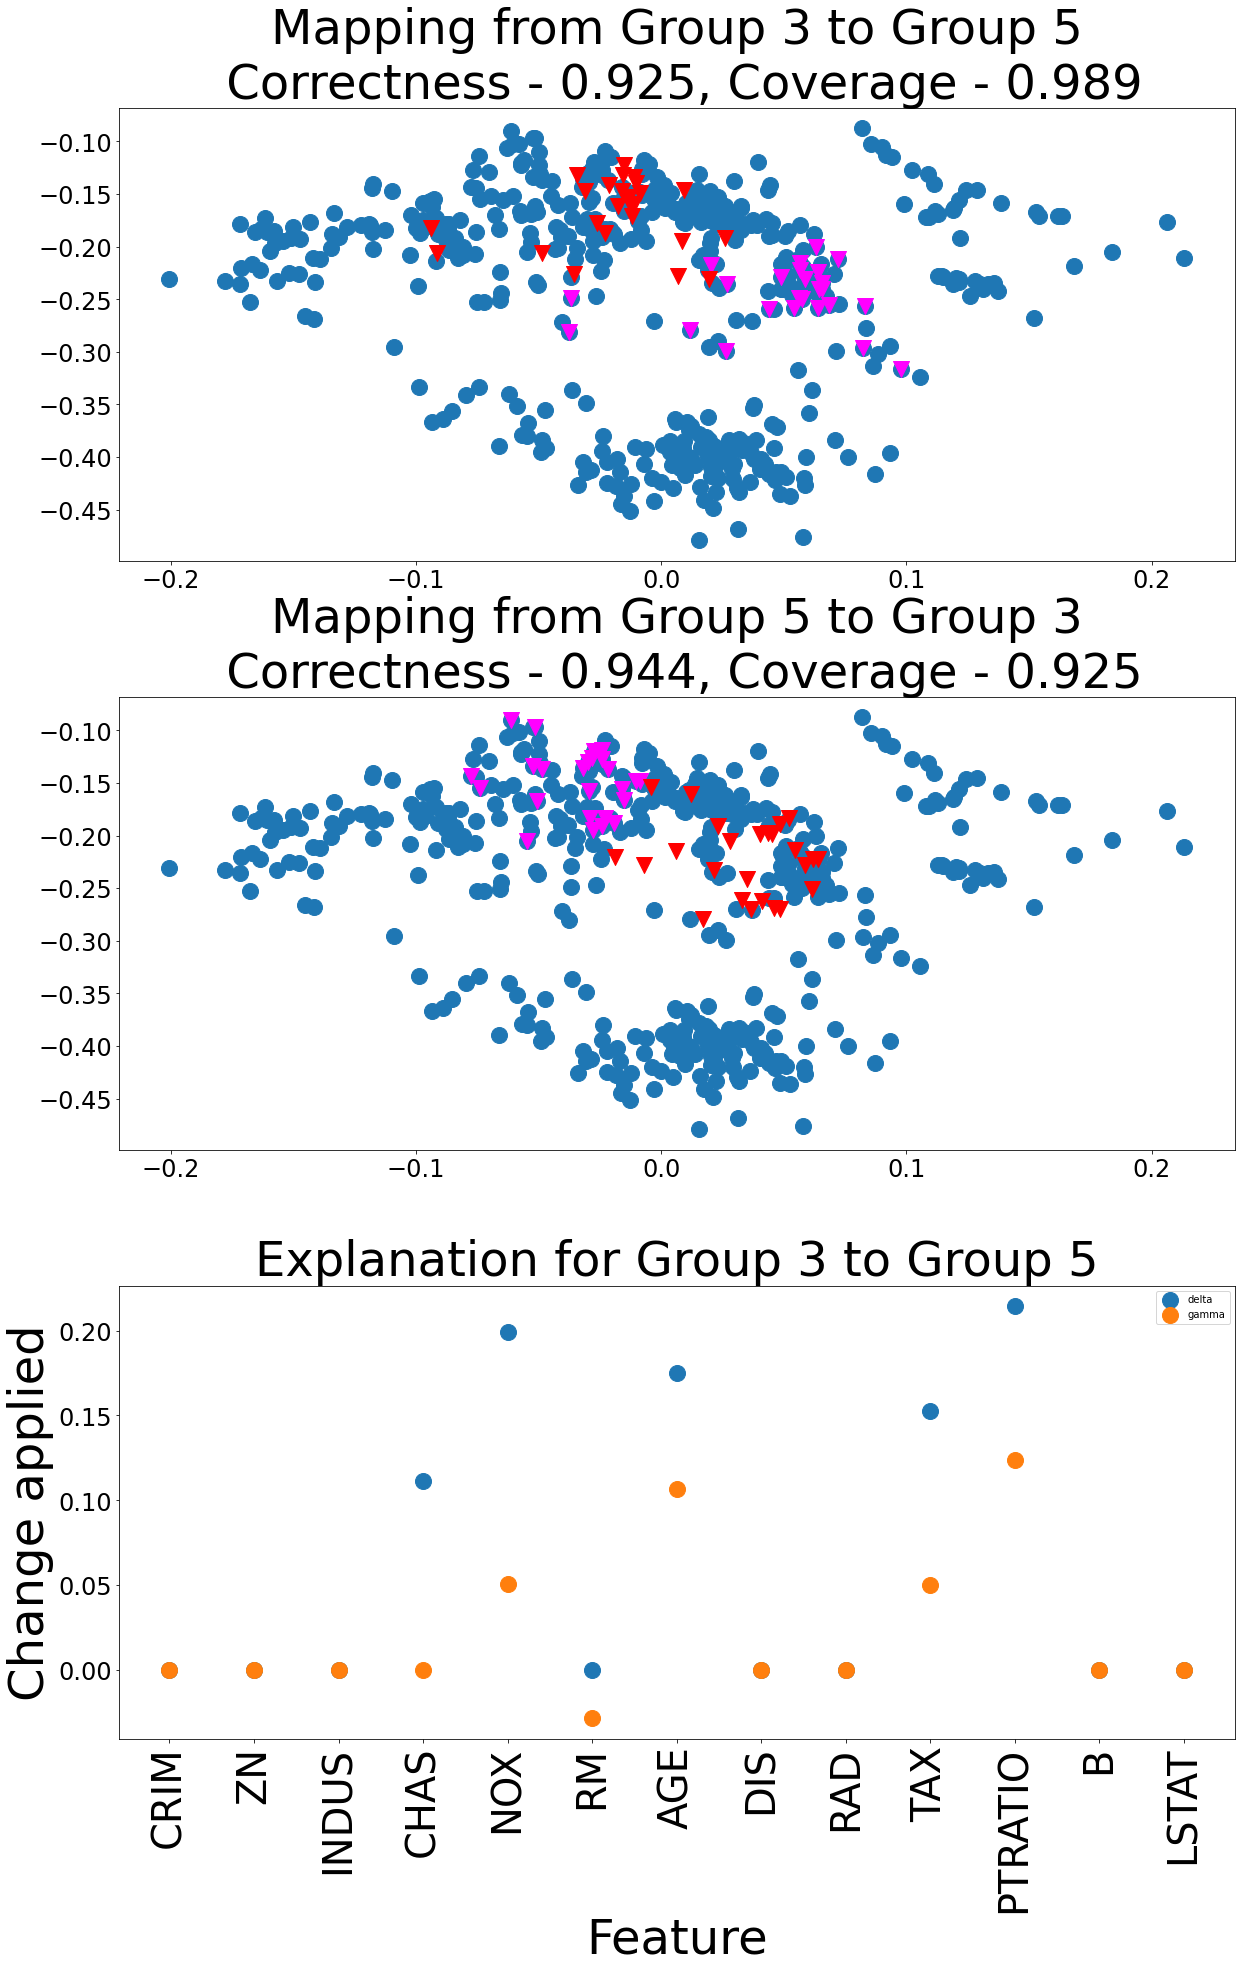

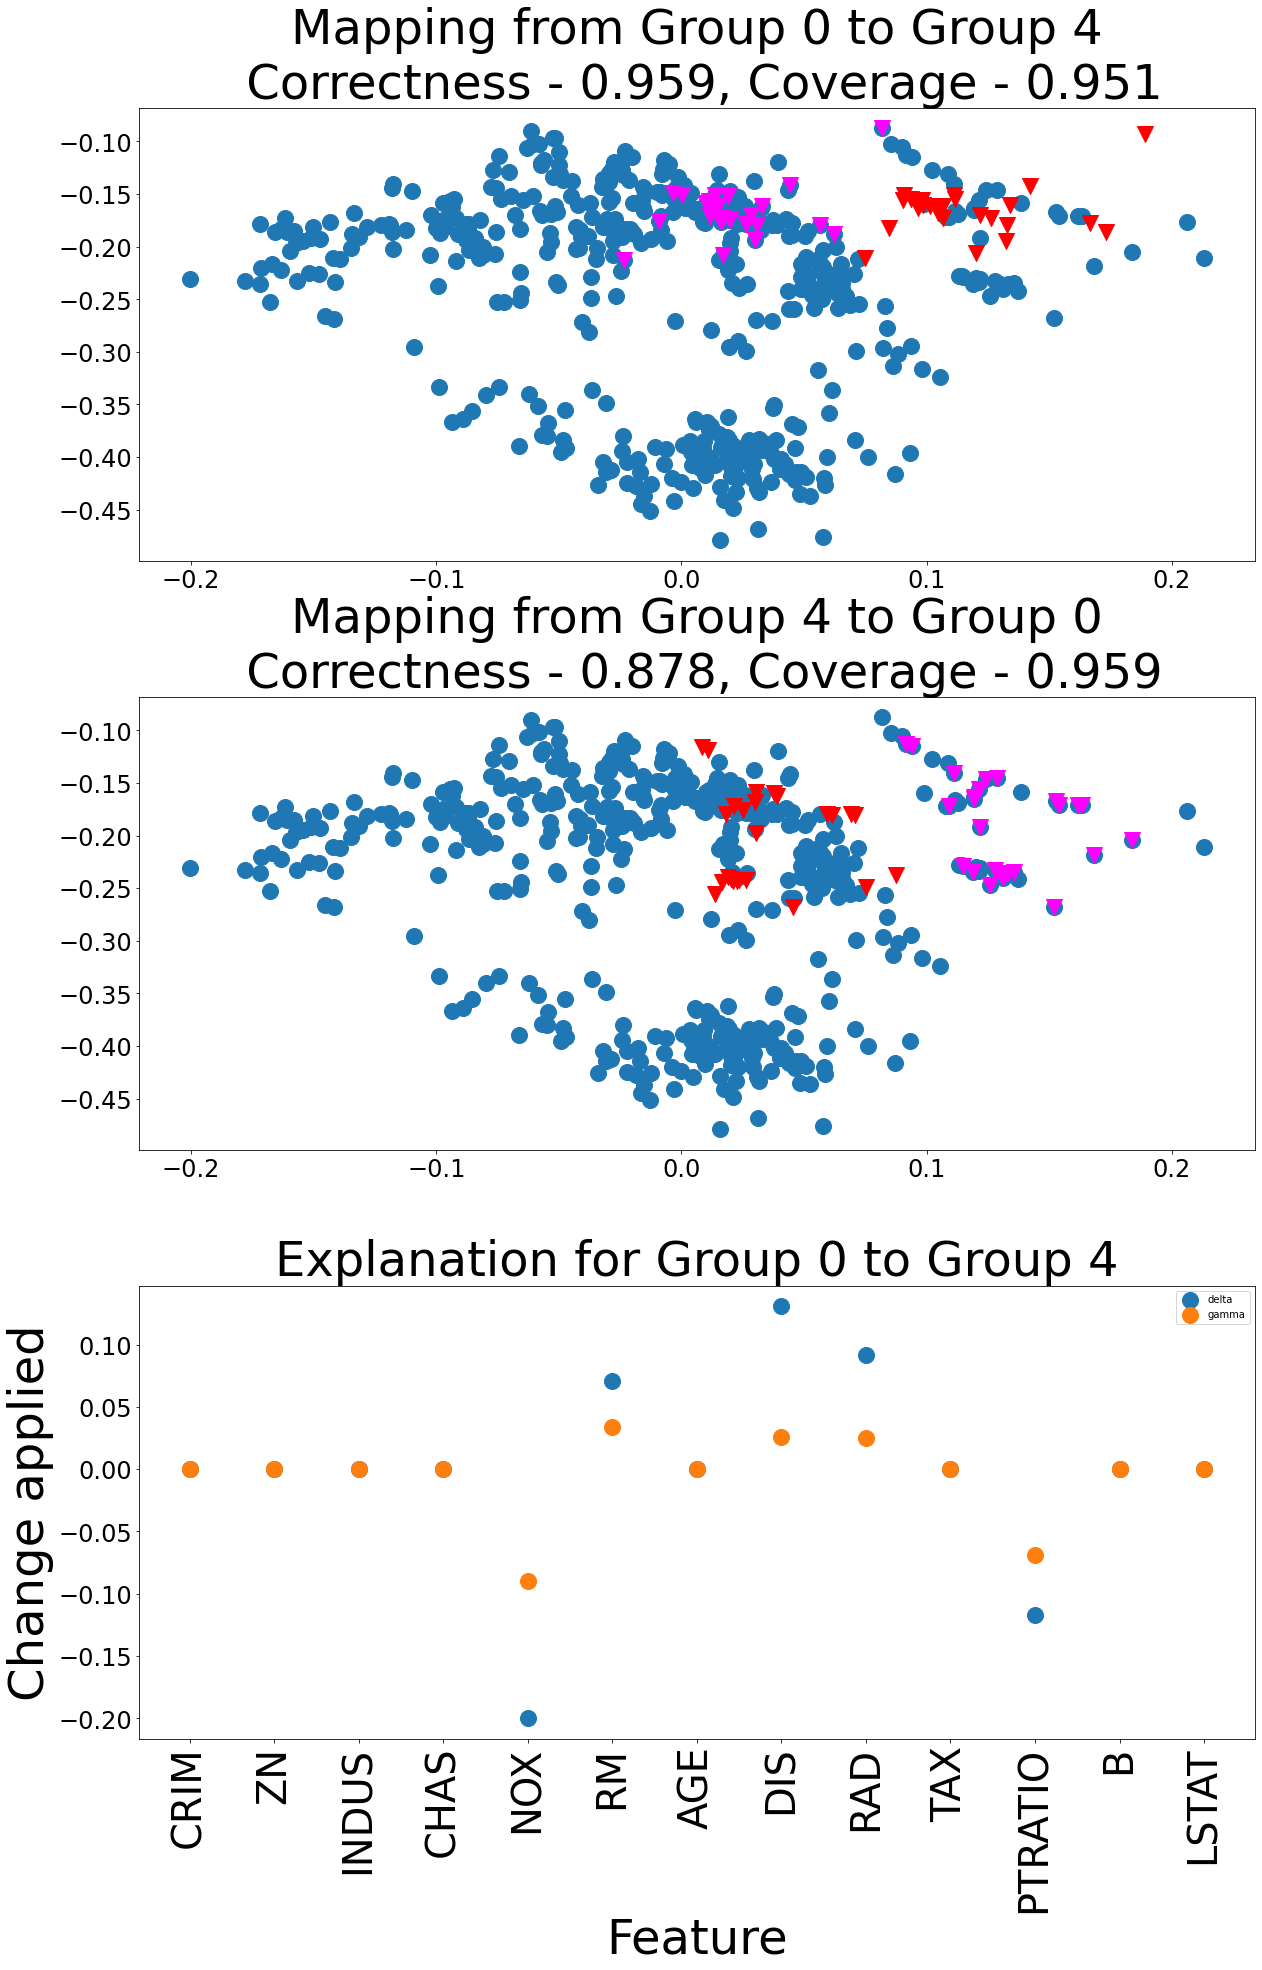

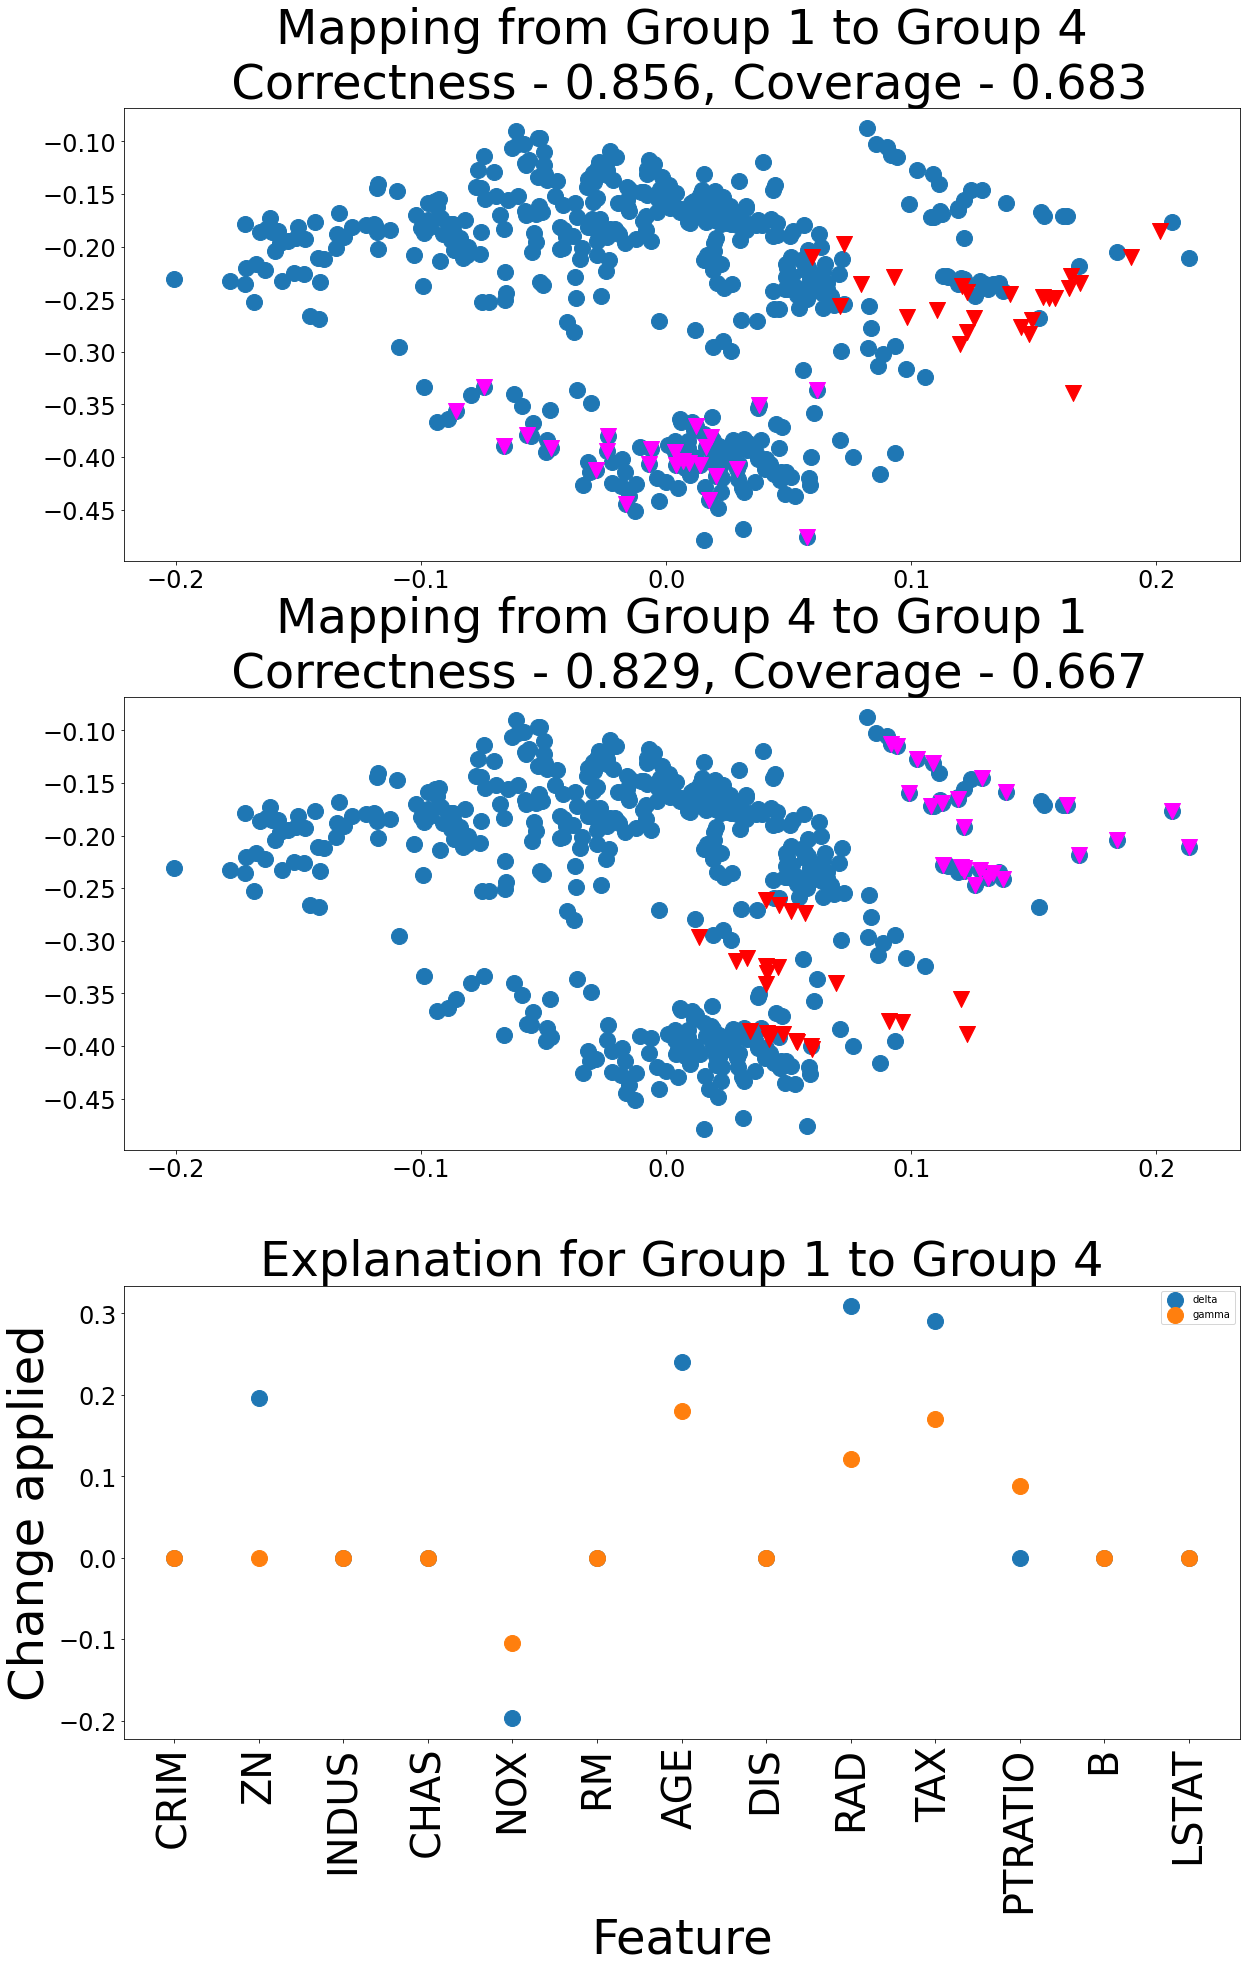

In [14]:
# Evaluate the explanations
# from eldr.plotter.myplot import *
k = 5
epsilon = 0.045
import torch
feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

deltas_ = np.load(f"{results_path}deltas" + str(k) + ".npy")
logit_gammas_ = np.load(f"{results_path}logit_gammas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)
print(logit_gammas_)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k, logit_gammas=torch.from_numpy(logit_gammas_))

plot_metrics(a, b, name = "housing-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "housing-0to2.png", feature_names = feature_names, logit_gammas=logit_gammas_)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 3, 5, k = k,  num_points = 25, name = "housing-3to5.png", feature_names = feature_names, logit_gammas=logit_gammas_)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 4, k = k,  num_points = 25, name = "housing-0to4.png", feature_names = feature_names, logit_gammas=logit_gammas_)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 4, k = k,  num_points = 25, name = "housing-1to4.png", feature_names = feature_names, logit_gammas=logit_gammas_)


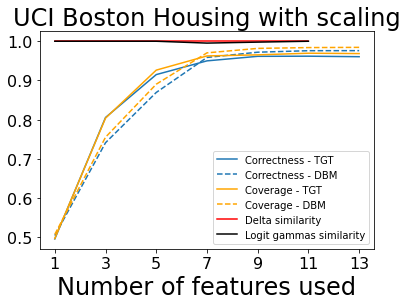

In [27]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
out_path = f'{base_path}experiments/Housing_scaling/out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_gammas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load(f"{results_path}deltas" + str(k_more) + ".npy")
    d_less = np.load(f"{results_path}deltas" + str(k_less) + ".npy")
    
    g_more = np.load(f"{results_path}logit_gammas" + str(k_more) + ".npy")
    g_less = np.load(f"{results_path}logit_gammas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    res_gammas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                
                e_g_more = load(g_more, k_more, i, j).numpy()
                e_g_less = load(g_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
                res_gammas[i,j] = Explainer.similarity(e_g_more, e_g_less)
    S_deltas[c] = np.mean(res_deltas)
    S_gammas[c] = np.mean(res_gammas)
    S_range.append(k_more)

plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.plot(S_range, S_gammas, c = 'black', label='Logit gammas similarity')

plt.xlabel('Number of features used')
plt.title('UCI Boston Housing with scaling')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("housing-scaling-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()